# <u><center>MODELOS DE MACHINE LEARNING</center></u>

En este notebook se recopilan todos los procedimientos llevados a cabo en el diseño, entrenamiento, optimización y predicción de los modelos de *machine learning*.


<br>
<br>

____


**CONTENIDOS**    
    
* [**Apartado 1**. Algoritmos de *machine learning*](#Ap1)
    * [1.1. Preprocesamiento previo](#1.1)
    * [1.2. División de los datos en *train* y *test sets*: *oversampling* y *categorical encoding*](#1.2)
    * [1.3. Visualización de los datos mediante PCA](#1.3) 
    * [1.4. Modelos de *machine learning*](#1.4)  
        * [1.4.1. Logistic Regression L2 (Ridge Regression)](#1.4.1)  
        * [1.4.2. Support Vector Classifier (SVC)](#1.4.2)  
        * [1.4.3. Random Forest](#1.4.3)   
        
    
* [**Apartado 2**. Ensemble Methods](#Ap2)
    * [2.1. VotingClassifier](#2.1)

    
* [**Apartado 3**. *Challenge dataset*: diseño y predicción](#Ap3)
    * [2.1. Carga de los datos](#3.1)
    * [2.2. Creación de la tabla con todos los descriptores](#3.2)
    * [2.3. Adaptación de la tabla a los requerimientos de los modelos ](#3.3)
    * [2.4. Predicción de los resultados](#3.4)

____


En primer lugar, se importan los paquetes y módulos necesarios:

In [1]:
import utils
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

A continuación, se carga la base de datos de trabajo:

In [2]:
wdf = pd.read_csv('corrected_FINAL_DDBB.csv', header = "infer")
wdf

type_of_variant mutation initial_aa final_aa topological_domain  \
0    pathogenic_variant      M1T          M        T        Cytoplasmic   
1    pathogenic_variant      M1V          M        V        Cytoplasmic   
2    pathogenic_variant      M1K          M        K        Cytoplasmic   
3    pathogenic_variant      G9D          G        D        Cytoplasmic   
4        benign_variant     A62V          A        V        Cytoplasmic   
..                  ...      ...        ...      ...                ...   
348      benign_variant    N780T          N        T        Cytoplasmic   
349      benign_variant    T847P          T        P        Cytoplasmic   
350  pathogenic_variant    P852L          P        L        Cytoplasmic   
351      benign_variant    R854C          R        C        Cytoplasmic   
352      benign_variant    R871S          R        S        Cytoplasmic   

    functional_domain  d_size  d_hf  d_vol  d_msa    d_charge     d_pol  \
0    unknown_function   30.09   2.6   28.8  -31.4  neu_to_neu   np_to_p   
1    unknown_function   32.06  -2.3   15.1  -15.7  neu_to_neu  np_to_np   
2    unknown_function    3.02   5.8   -5.2  -50.4  neu_to_pos   np_to_p   
3    unknown_function  -58.03   3.1  -31.3    9.0  neu_to_neg    p_to_p   
4    unknown_function  -28.06  -2.4  -31.8   17.8  neu_to_neu  np_to_np   
..                ...     ...   ...    ...    ...         ...       ...   
348  unknown_function   13.00  -2.8    1.4   10.8  neu_to_neu    p_to_p   
349  unknown_function    3.99   0.9   -7.0  -30.9  neu_to_neu   p_to_np   
350  unknown_function  -16.04  -5.4  -22.6   56.1  neu_to_neu  np_to_np   
351  unknown_function   53.04  -7.0   42.8   42.7  pos_to_neu    p_to_p   
352  unknown_function   69.11  -3.7   52.7    9.6  pos_to_neu    p_to_p   

        d_aro  residue_conserv secondary_str  pLDDT str_pos    MTR  label  
0    na_to_na          0.61970          coil  35.85    GAP1  0.730      1  
1    na_to_na          0.61970          coil  35.85    GAP1  0.730      1  
2    na_to_na          0.61970          coil  35.85    GAP1  0.730      1  
3    na_to_na          0.59054          coil  39.91    GAP1  0.669      1  
4    na_to_na          0.54134          coil  35.21    GAP1  0.754      0  
..        ...              ...           ...    ...     ...    ...    ...  
348  na_to_na          0.56080          coil  30.20    GAP4  0.838      0  
349  na_to_na          0.68392          coil  33.66    GAP4  0.771      0  
350  na_to_na          0.59805          coil  38.32    GAP4  0.797      1  
351  na_to_na          0.47339          coil  29.43    GAP4  0.811      0  
352  na_to_na          0.53425          coil  30.57    GAP4  0.847      0  

[353 rows x 19 columns]

<br>
<br>

## <font color = "blue"> APARTADO 1. ALGORITMOS DE MACHINE LEARNING </font><a id="Ap1"></a>

### 1.1. Preprocesamiento previo <a id ="1.1"></a>

En primer lugar se va a realizar una limpieza de ***outliers***. A continuación, unos **análisis exploratorios de los datos** en donde se comprobarán la existencia o no de **duplicados** y ***missing values***.

<br>

<u>**Corrección de *outliers***</u>

Se visualizan los descriptores cuantitativos mediante *boxplots* con el fin de detectar *outliers*.

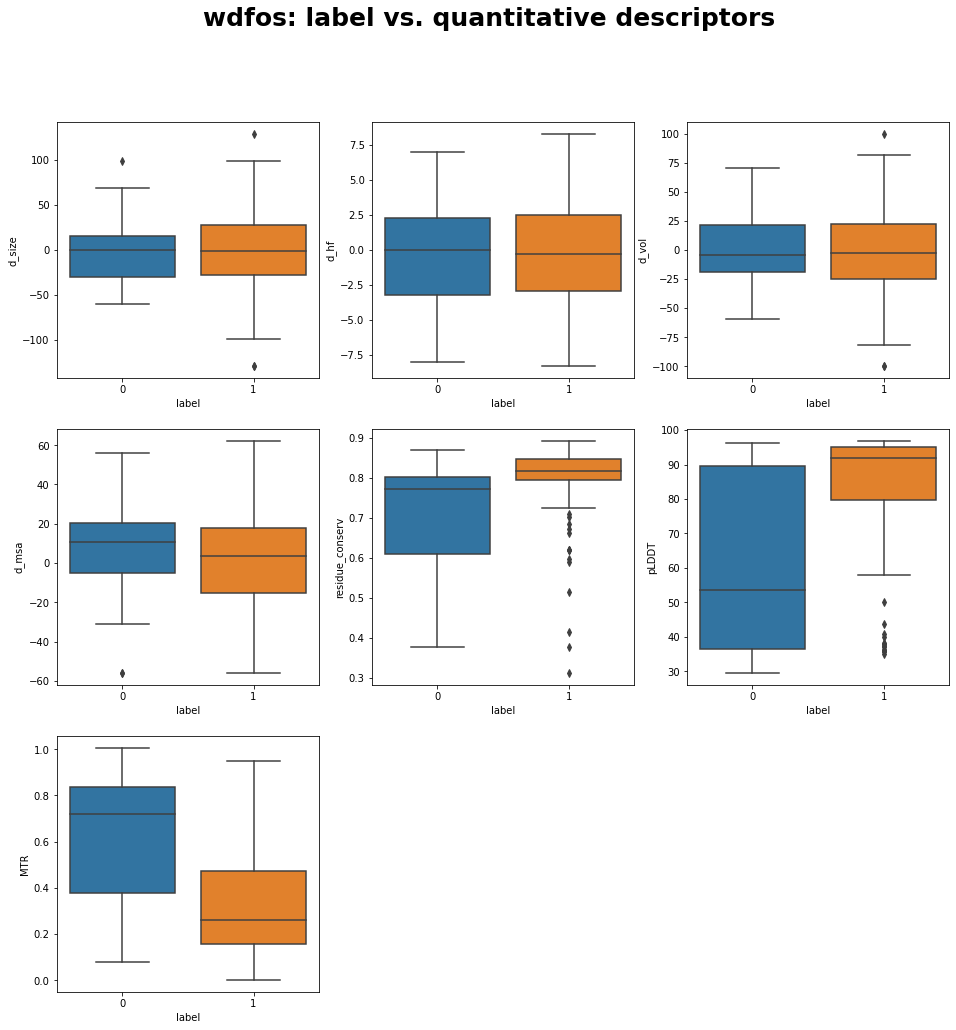

In [3]:
plt.figure(figsize=(16, 16))
plt.suptitle('wdfos: label vs. quantitative descriptors', weight= "bold", size = 25)

c = 0
for d in wdf.select_dtypes(include=['int64', 'float64']):
    if d != "label":
        c +=1
        plt.subplot(3, 3, c)
        ax = sns.boxplot(x = wdf["label"], y = wdf[d])

plt.show()

Se va a proceder a analizar por separado el descriptor de `residue_conservation` por ser el más relevante a la hora de predecir la etiqueta y por ser el que más outliers presenta también.

The extreme values are 0.31154, 0.37813, 0.41429, 0.5132, 0.59054, 0.59805, 0.6197, 0.6197 and 0.6197

List with outliers is 314 long
List without outliers is 305 long


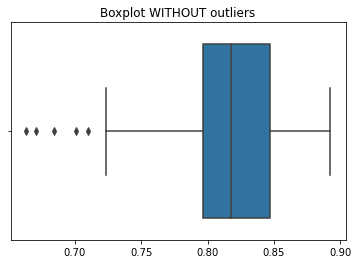

In [4]:
x1=list(wdf.loc[(wdf["label"] == 1)]["residue_conserv"])
l = []

for i in x1:
    l.append(i)

#Identify extreme values
print("The extreme values are {}, {}, {}, {}, {}, {}, {}, {} and {}".format(sorted(l)[0], 
                                                                            sorted(l)[1],
                                                                            sorted(l)[2], 
                                                                            sorted(l)[3],
                                                                            sorted(l)[4],
                                                                            sorted(l)[5],
                                                                            sorted(l)[6],
                                                                            sorted(l)[7],
                                                                            sorted(l)[8]))
# Remove outliers and plot results
new_l = sorted(l)[9:]

print()
print("List with outliers is {} long".format(len(l)))
print("List without outliers is {} long".format(len(new_l)))

sns.boxplot(x=new_l).set_title("Boxplot WITHOUT outliers")
plt.show()

Este bloxplot está más adaptado que el anterior al haber eliminado los *outliers* más extremos. A continuación, se eliminan esas entradas del dataframe de trabajo (`wdf`).

In [5]:
wdf = wdf.drop(wdf.loc[(wdf["label"] == 1) & (wdf["residue_conserv"] <= 0.6197)].index)
wdf

type_of_variant mutation initial_aa final_aa topological_domain  \
4        benign_variant     A62V          A        V        Cytoplasmic   
5    pathogenic_variant     N79K          N        K        Cytoplasmic   
6        benign_variant     L81P          L        P        Cytoplasmic   
7    pathogenic_variant     P88L          P        L        Cytoplasmic   
8    pathogenic_variant     H96P          H        P                 S1   
..                  ...      ...        ...      ...                ...   
347      benign_variant    A761S          A        S        Cytoplasmic   
348      benign_variant    N780T          N        T        Cytoplasmic   
349      benign_variant    T847P          T        P        Cytoplasmic   
351      benign_variant    R854C          R        C        Cytoplasmic   
352      benign_variant    R871S          R        S        Cytoplasmic   

    functional_domain  d_size  d_hf  d_vol  d_msa    d_charge     d_pol  \
4    unknown_function  -28.06  -2.4  -31.8   17.8  neu_to_neu  np_to_np   
5    unknown_function  -14.07   0.4  -32.6   -8.2  neu_to_pos    p_to_p   
6    unknown_function   16.04   5.4   22.6  -56.1  neu_to_neu  np_to_np   
7    unknown_function  -16.04  -5.4  -22.6   56.1  neu_to_neu  np_to_np   
8      voltage_domain   40.03  -1.6    8.2  -38.1  pos_to_neu   p_to_np   
..                ...     ...   ...    ...    ...         ...       ...   
347  unknown_function  -16.00   2.6   -2.2   -3.1  neu_to_neu   np_to_p   
348  unknown_function   13.00  -2.8    1.4   10.8  neu_to_neu    p_to_p   
349  unknown_function    3.99   0.9   -7.0  -30.9  neu_to_neu   p_to_np   
351  unknown_function   53.04  -7.0   42.8   42.7  pos_to_neu    p_to_p   
352  unknown_function   69.11  -3.7   52.7    9.6  pos_to_neu    p_to_p   

        d_aro  residue_conserv   secondary_str  pLDDT str_pos    MTR  label  
4    na_to_na          0.54134            coil  35.21    GAP1  0.754      0  
5    na_to_na          0.72360           helix  86.53   FRAG1  0.597      1  
6    na_to_na          0.61123           helix  88.78   FRAG1  0.480      0  
7    na_to_na          0.74223            coil  74.41   FRAG1  0.441      1  
8    na_to_na          0.77205  membrane_helix  88.17   FRAG1  0.429      1  
..        ...              ...             ...    ...     ...    ...    ...  
347  na_to_na          0.58570            coil  35.95    GAP4  0.857      0  
348  na_to_na          0.56080            coil  30.20    GAP4  0.838      0  
349  na_to_na          0.68392            coil  33.66    GAP4  0.771      0  
351  na_to_na          0.47339            coil  29.43    GAP4  0.811      0  
352  na_to_na          0.53425            coil  30.57    GAP4  0.847      0  

[344 rows x 19 columns]

<br>

<u>**Análisis exploratorio de los datos**</u>

En primer lugar, se comprueba o no la existencia de **duplicados** o ***missing values***.

In [6]:
# Check for duplicates 
wdf[wdf["mutation"].duplicated()]

Empty DataFrame
Columns: [type_of_variant, mutation, initial_aa, final_aa, topological_domain, functional_domain, d_size, d_hf, d_vol, d_msa, d_charge, d_pol, d_aro, residue_conserv, secondary_str, pLDDT, str_pos, MTR, label]
Index: []

In [7]:
# Check for missing values
wdf.isnull().sum()

type_of_variant       0
mutation              0
initial_aa            0
final_aa              0
topological_domain    0
functional_domain     0
d_size                0
d_hf                  0
d_vol                 0
d_msa                 0
d_charge              0
d_pol                 0
d_aro                 0
residue_conserv       0
secondary_str         0
pLDDT                 0
str_pos               0
MTR                   0
label                 0
dtype: int64

Una vez se ha visto que no hay duplicados ni *missing values*, se realiza una visualización de la distribución de clases en el dataframe de trabajo:

The data has 344 entries and 19 attributes.
We also have:
 39 benign mutations
 305 pathological mutations


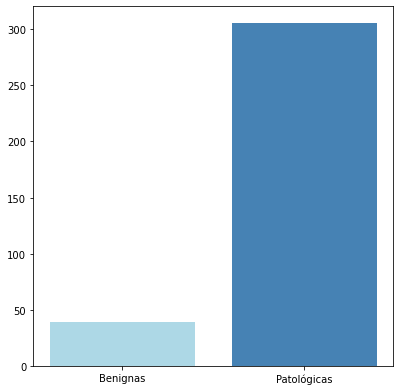

In [8]:
y_be = (wdf.values[:,-1] == 0)
y_pa = (wdf.values[:,-1] == 1)

print("The data has", wdf.shape[0],"entries and", wdf.shape[1],"attributes.")
print("We also have:\n",str(sum(y_be))+" benign mutations\n", str(sum(y_pa))+" pathological mutations")

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
labels = ["Benignas", "Patológicas"]
data = [sum(y_be),sum(y_pa)]
ax.bar(labels,data,color = ["lightblue","steelblue"])

plt.show()

Así, se observa el claro desequilibrio de clases presente en el dataframe de trabajo.

<br>
<br>

### 1.2. División de los datos en *train* y *test sets*: *oversampling* y *categorical encoding* <a id = "1.2"></a>

En primer lugar, se dividen los datos en *train* y *test sets*:

In [9]:
X = wdf.values[:,2:-1]
y = wdf.values[:,-1].astype('int')

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1012)

print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(258, 16)
(86, 16)

(258,)
(86,)


<br>

<u>***Oversampling***</u>

Debido al desbalanceo de clases observados en el [preprocesamiento](#1.1), se prueba la técnica de ***oversampling***, que consiste en balancear el dataset aumentando el tamaño de las muestras raras. Esta técnica está recomendada para conjuntos de datos pequeños. Se emplea el módulo [**sklearn.utils.resample**](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html).


Este procedimiento es necesario hacerlo después de la división en `X_train/y_train` y `X_test/y_test` desde que solo se puede aplicar al conjunto de datos de `X_train`.

In [10]:
# Create a df of X_train and y_train
X_train_dfos = pd.DataFrame(X_train, columns = ['initial_aa', 
                                                'final_aa', 
                                                'topological_domain', 
                                                'functional_domain', 
                                                'd_size',
                                                'd_hf',
                                                'd_vol',
                                                'd_msa',
                                                'd_charge', 
                                                'd_pol', 
                                                'd_aro', 
                                                'residue_conserv',
                                                'secondary_str',
                                                'pLDDT',
                                                'str_pos',
                                                'MTR'])

y_train_dfos = pd.DataFrame(y_train, columns = ['label'])

In [11]:
##################### Oversampling ###########################
# Concatenate our training data back together
dfos = pd.concat([X_train_dfos, y_train_dfos], axis=1)

# Separate majority and minority classes
# Separate majority and minority classes
df_majority = dfos[dfos.label==1]
df_minority = dfos[dfos.label==0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority)//2,    
                                 random_state=0)   # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()

1    227
0    113
Name: label, dtype: int64

Así, se consigue mantener las 236 mutaciones patológicas que ya existían en el *trainig set* (`label = 1`) y se han creado un total de 90 mutaciones benignas sintéticas empleando las 28 mutaciones benignas originales del *trainig set* (`label = 0`).

In [12]:
# Oversampled train datasets for machine learning models
X_train_os = df_upsampled.values[:,:-1]
y_train_os = df_upsampled.values[:,-1].astype("int")

<br>

<u>***Categorical encoding***</u>

Se va a emplear la información recopilada de [Dipanjan Saker](https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63) y de [Jason Brownlee](https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/). Es necesario  codificar la información categórica desde que los algoritmos de *machine learning* no están destinados a trabajar con este tipo de información. Siguiendo las instrucciones de [Jason Brownlee](https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/), primero se van a dividir los datos en *train* y *test* set. Posteriormente, se aplicarán las transformaciones y codificaciones pertinentes en los datos categóricos (siguiendo las instrucciones de [Dipanjan Saker](https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63)).  Es necesario dividir en *train* y *test sets* antes de realizar la codificación.

Ahora, interesa codificar las variables cualitativas que aparecen en los conjuntos `X_train` y `X_test`. Para ello, tendré que aplicar ***Feature engineering*** sobre ellas:
* En primer lugar realizaré una **transformación** de los datos mediante **`LabelEncoder()`** para convertir los datos en números.
* En segundo lugar aplicaré un **esquema de codificación** de los números mediante **`OneHotEncoder()`** para evitar relaciones numéricas inexistentes. 

Esto se realiza así porque la codificación **no va a ocasionar problemas de memoria** según el esquema de [Feature Labs](https://www.kdnuggets.com/wp-content/uploads/garg_cat_variables_15.jpg). Creo una función para automatizar el proceso:

In [13]:
X_train_enc, X_test_enc, X_train_df, X_test_df = utils.categorical_encoding(X_train_os, X_test)
print(X_train_enc.shape)
print(X_test_enc.shape)

(340, 95)
(86, 95)


Para ver el número de mutaciones patológicas en el *train* y en el *test set*:

In [14]:
print("El número de mutaciones en el training set es de:")
print("· {} benignas".format(np.unique(y_train_os, return_counts=True)[1][0]))
print("· {} patológicas".format(np.unique(y_train_os, return_counts=True)[1][1]))

print()

print("El número de mutaciones en el test set es de:")
print("· {} benignas".format(np.unique(y_test, return_counts=True)[1][0]))
print("· {} patológicas".format(np.unique(y_test, return_counts=True)[1][1]))

El número de mutaciones en el training set es de:
· 113 benignas
· 227 patológicas

El número de mutaciones en el test set es de:
· 8 benignas
· 78 patológicas


In [15]:
X_train_df.columns

Index(['d_size', 'd_hf', 'd_vol', 'd_msa', 'residue_conserv', 'plddt', 'MTR',
       'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
       'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'Cytoplasmic', 'Extracelullar', 'Pore', 'S1', 'S2', 'S3', 'S4', 'S5',
       'S6', 'hA', 'hB', 'hC', 'hD', 'hTW', 'CaM_interaction', 'SID_domain',
       'pore_domain', 'selectivity_filter', 'unknown_function',
       'voltage_domain', 'neg_to_neg', 'neg_to_neu', 'neg_to_pos',
       'neu_to_neg', 'neu_to_neu', 'neu_to_pos', 'pos_to_neg', 'pos_to_neu',
       'pos_to_pos', 'np_to_np', 'np_to_p', 'p_to_np', 'p_to_p', 'a_to_a',
       'a_to_na', 'na_to_a', 'na_to_na', 'beta_strand', 'coil', 'helix',
       'membrane_helix', 'FRAG1', 'FRAG2', 'FRAG3', 'GAP1', 'GAP2', 'GAP3',
       'GAP4'],
      dtype='object')

<br>
<br>

### 1.3. Visualización de los datos mediante PCA <a id = "1.3"></a>
Por último, se realiza una rápida visualización mediante PCA para ver la localización de las mutaciones benignas y patológicas según las componentes principales.

In [16]:
# Represent only continuos features
df = wdf.iloc[:,:].select_dtypes(include=['int64', 'float64'])

#Standarize
X = StandardScaler().fit_transform(df[['d_size', 'd_hf','d_vol','d_msa',
                                       'residue_conserv', 'pLDDT', 'MTR']])

pca = PCA(n_components=4)
components = pca.fit_transform(X)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}


fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color_discrete_sequence=["royalblue", "tomato"],
    color=df["label"].astype("str"),
)
fig.update_traces(diagonal_visible=False)
fig.show()

Visto el anterior gráfico, se representa en 3D (`n_components = 3`) para explicar un 95.86% de la variabilidad de los datos:

In [17]:
# Represent only continuos features
df = wdf.iloc[:,:].select_dtypes(include=['int64', 'float64'])

#Standarize
X = StandardScaler().fit_transform(df[['d_size', 'd_hf','d_vol','d_msa',
                                       'residue_conserv', 'pLDDT',
                                      'MTR']])

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color_discrete_sequence=["royalblue", "tomato"],
    color=df["label"].astype("str"),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

)
fig.show() # 1 = pathogenic; 0 = benign

Se explica menos variabilidad. Además, la nube "sube" pero parece que las mutaciones patológicas se desplazan hacia la derecha. Parece que se separan mejor pero tampoco de una manera excelente.

<br>
<br>

### 1.4. Modelos de *machine learning* <a id = "1.4"></a>

Se muestran solo los mejores resultados:

#### 1.4.1 Logistic Regression L2 (Ridge Regression) <a id = "1.4.1"></a>
Se muestra el mejor modelo de LR2 tras previo ajuste de hiperparámetros con GridSearch:

AUC-ROC VALUES:
             Roc-auc
     Train      0.92
      Test      0.89
[[0.9161436201317688], [0.8926282051282051]]
CONFUSION MATRIX:
Train:


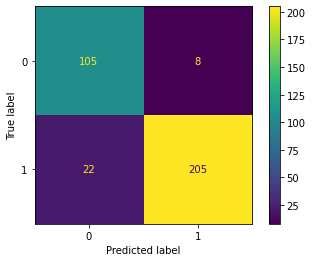

· 92.92035398230088 % predicted bening variants.
· 90.30837004405286 % predicted pathological variants.
Test:


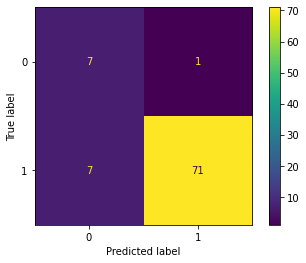

· 87.5 % predicted bening variants.
· 91.02564102564102 % predicted pathological variants.


In [18]:
X_train_fs, X_test_fs, featL2, posL2 = utils.select_features(X_train_enc,
                                                                    X_train_df, 
                                                                    y_train_os,
                                                                    X_test_enc, 
                                                                    n = 45)
# + feature selection --> 45
pipeline_LR1 = Pipeline( [("scaler", StandardScaler()), \
                                                     ("logistic", LogisticRegression(solver = "saga",
                                                                                        penalty = "l2",
                                                                                        max_iter = 10000,
                                                                                        class_weight = {0: 3, 1: 2},
                                                                                        multi_class = "ovr",
                                                                                        C = 2.91, # C = 1
                                                                                        random_state = 8))] ) 
pipeline_LR1.fit(X_train_fs, y_train_os)

print("AUC-ROC VALUES:")
print(utils.get_roc_auc_score(pipeline_LR1, X_train_fs, y_train_os, 
                                  X_test_fs, y_test, print_table=True))

print("CONFUSION MATRIX:")
print("Train:")
utils.metrics(pipeline_LR1, X_train_fs,y_train_os)
print("Test:")
utils.metrics(pipeline_LR1, X_test_fs,y_test)

<br>
<br>

#### 1.4.2 Support Vector Classifier (SVC) <a id = "1.4.2"></a>
Se muestra el mejor modelo de SVC tras previo ajuste de hiperparámetros con GridSearch:

AUC-ROC VALUES:
             Roc-auc
     Train      0.90
      Test      0.89
[[0.9028302990136838], [0.8862179487179487]]
CONFUSION MATRIX:
Train:


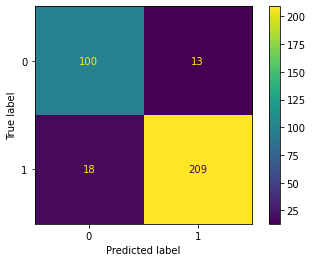

· 88.49557522123894 % predicted bening variants.
· 92.07048458149781 % predicted pathological variants.
Test:


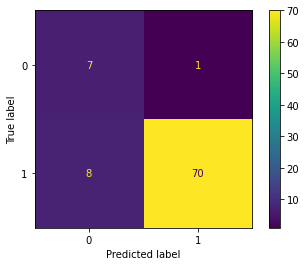

· 87.5 % predicted bening variants.
· 89.74358974358975 % predicted pathological variants.


In [19]:
X_train_fs, X_test_fs, featSVC, posSVC = utils.select_features(X_train_enc,
                                                                    X_train_df, 
                                                                    y_train_os,
                                                                    X_test_enc, 
                                                                    n = 45)
pipeline_SVC = Pipeline( [("scaler", StandardScaler()), \
                          ("SVC", SVC(kernel = "linear", 
                                      class_weight= {0:1, 1:1},
                                                     probability=True,
                                                     decision_function_shape = "ovr",
                                                     degree = 2,
                                                     gamma = "auto", 
                                                     C = 1,
                                                     random_state = 45))] )

pipeline_SVC.fit(X_train_fs, y_train_os)

print("AUC-ROC VALUES:")
print(utils.get_roc_auc_score(pipeline_SVC, X_train_fs, y_train_os, 
                                  X_test_fs, y_test, print_table=True))

print("CONFUSION MATRIX:")
print("Train:")
utils.metrics(pipeline_SVC, X_train_fs,y_train_os)
print("Test:")
utils.metrics(pipeline_SVC, X_test_fs,y_test)

<br>
<br>

#### 1.4.3 Random Forest <a id = "1.4.3"></a>
Se muestra el mejor modelo de RF tras previo ajuste de hiperparámetros con GridSearch:

AUC-ROC VALUES:
             Roc-auc
     Train      0.88
      Test      0.87
[[0.8807843748781724], [0.8733974358974359]]
CONFUSION MATRIX:
Train:


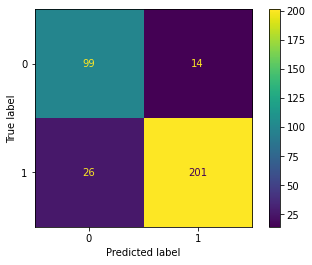

· 87.61061946902655 % predicted bening variants.
· 88.54625550660793 % predicted pathological variants.
Test:


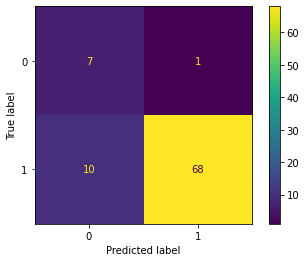

· 87.5 % predicted bening variants.
· 87.17948717948718 % predicted pathological variants.


In [20]:
X_train_fs, X_test_fs, featRF, posRF = utils.select_features(X_train_enc,
                                                                    X_train_df, 
                                                                    y_train_os,
                                                                    X_test_enc, 
                                                                    n = 45)
pipeline_RF = Pipeline( [("scaler", StandardScaler()), \
                         ("RF", RandomForestClassifier(max_depth = 3,
                                                       criterion = "log_loss",
                                                       max_features = "log2",
                                                       oob_score = False,
                                                       min_samples_split = 2, # min = 5
                                                       class_weight= {0:3, 1:1},
                                                       random_state = 45))] )

pipeline_RF.fit(X_train_fs, y_train_os)

print("AUC-ROC VALUES:")
print(utils.get_roc_auc_score(pipeline_RF, X_train_fs, y_train_os, 
                                  X_test_fs, y_test, print_table=True))

print("CONFUSION MATRIX:")
print("Train:")
utils.metrics(pipeline_RF, X_train_fs,y_train_os)
print("Test:")
utils.metrics(pipeline_RF, X_test_fs,y_test)

<br>
<br>

## <font color = "blue"> APARTADO 2. Ensemble Methods </font><a id="Ap2"></a>

### 2.1. VotingClassifier </font><a id="2.1"></a>
Creo este apartado para crear un único clasificador que realice la predicción a partir de los tres modelos entrenados. Al fin y al cabo, a los clínicos les interesaría meter su input y recibir un output... no tener en cuenta tres predicciones distintas para tomar una decisión. Para ello, voy a emplear [`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) de sklearn.

AUC-ROC VALUES:
             Roc-auc
     Train      0.92
      Test      0.89
[[0.920548906475381], [0.8926282051282051]]
CONFUSION MATRIX:
Train:


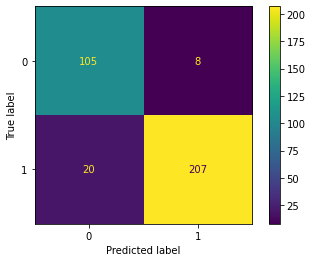

· 92.92035398230088 % predicted bening variants.
· 91.18942731277532 % predicted pathological variants.
Test:


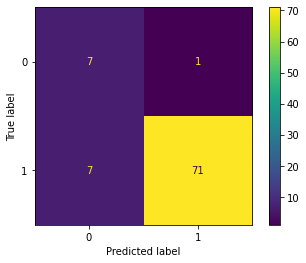

· 87.5 % predicted bening variants.
· 91.02564102564102 % predicted pathological variants.


In [21]:
X_train_fs, X_test_fs, featEn, posEn = utils.select_features(X_train_enc,
                                                             X_train_df, 
                                                             y_train_os,
                                                             X_test_enc, 
                                                             n = 45)



pipeline_ensemble_soft = Pipeline( [("scaler", StandardScaler()), \
                                        ("Ensemble_soft", VotingClassifier(voting = "soft",
                                                                            weights = [1,0.5,1.75],
                                                                            estimators=[
                                         ("logistic", LogisticRegression(solver = "saga",
                                                                                    penalty = "l2",
                                                                                    max_iter = 10000,
                                                                                    class_weight = {0: 3, 1: 2},
                                                                                    multi_class = "ovr",
                                                                                    C = 2.91,
                                                                                    random_state = 8)),
                                       ("SVC", SVC(kernel = "linear", 
                                                  class_weight= {0:1, 1:1},
                                                                 probability=True,
                                                                 decision_function_shape = "ovr",
                                                                 degree = 2,
                                                                 gamma = "auto", 
                                                                 C = 1,
                                                                 random_state = 45)),
                                        ("RF", RandomForestClassifier(max_depth = 3,
                                                   criterion = "log_loss",
                                                   max_features = "log2",
                                                   oob_score = False,
                                                   min_samples_split = 2, # min = 5
                                                   class_weight= {0:3, 1:1},
                                                   random_state = 45))]))])
pipeline_ensemble_soft.fit(X_train_fs, y_train_os)

print("AUC-ROC VALUES:")
print(utils.get_roc_auc_score(pipeline_ensemble_soft, X_train_fs, y_train_os, 
                                  X_test_fs, y_test, print_table=True))

print("CONFUSION MATRIX:")
print("Train:")
utils.metrics(pipeline_ensemble_soft, X_train_fs,y_train_os)
print("Test:")
utils.metrics(pipeline_ensemble_soft, X_test_fs,y_test)

<br>
<br>

## <font color = "blue"> APARTADO 3. Predicción </font><a id="Ap3"></a>

Empleando el ensemble diseñado en pasos anteriores:

### 3.1 Carga de los datos <a id ="3.1"></a>

Se cargan tanto las mutaciones "conflictivas" como las de "significancia desconocida". La fecha de ambos ficheros es la misma: (16/09/21).

In [22]:
# Load file and select needed columns
arr = pd.read_csv('./clinvar_result_conflictive.txt', sep='\t')
arr = arr.loc[:, ["Protein change", "Clinical significance (Last reviewed)"]]

# Select only first mutation if a row has multiple
mut = [i.split(",")[0] for i in arr["Protein change"]]

# Create a dataframe with it 
conf = pd.DataFrame(mut, columns = ["Mutationppt"])

In [23]:
# Load file and select needed columns
arr = pd.read_csv('./clinvar_result_uncertain.txt', sep='\t')
arr = arr.loc[:, ["Protein change", "Clinical significance (Last reviewed)"]]

# Select only first mutation if a row has multiple
mut = [i.split(",")[0] for i in arr["Protein change"]]

# Create a dataframe with it 
uncertain = pd.DataFrame(mut, columns = ["Mutationppt"])

Se unen ambos dataframes:

In [24]:
challenge = pd.concat([conf,uncertain], axis = 0, join = "outer")

In [25]:
print("Conflictive_variants", conf.shape)
print("Uncertain_variants", uncertain.shape)

print("Total challenge", challenge.shape)

Conflictive_variants (39, 1)
Uncertain_variants (254, 1)
Total challenge (293, 1)


### 3.2 Creación de la tabla con los descriptores <a id ="3.2"></a>

In [26]:
# Use utils KNCQ2_DDBB_generation function to create all descriptors
ch_df = utils.KCNQ2_DDBB_generation(challenge)

ch_df

Mutationppt initial_aa final_aa  position_aa     Location  \
253         K4N          K        N            4  Cytoplasmic   
252         R6P          R        P            6  Cytoplasmic   
251         G8C          G        C            8  Cytoplasmic   
250         G8S          G        S            8  Cytoplasmic   
249        Y11H          Y        H           11  Cytoplasmic   
..          ...        ...      ...          ...          ...   
5         P852L          P        L          852  Cytoplasmic   
4         S855L          S        L          855  Cytoplasmic   
3         G858S          G        S          858  Cytoplasmic   
2         F862L          F        L          862  Cytoplasmic   
1         A868P          A        P          868  Cytoplasmic   

    functional_domain char_initial_aa   char_final_aa pol_initial_aa  \
253  unknown_function  positive_basic         neutral          polar   
252  unknown_function  positive_basic         neutral          polar   
251  unknown_function         neutral         neutral          polar   
250  unknown_function         neutral         neutral          polar   
249  unknown_function         neutral  positive_basic      non_polar   
..                ...             ...             ...            ...   
5    unknown_function         neutral         neutral      non_polar   
4    unknown_function         neutral         neutral          polar   
3    unknown_function         neutral         neutral          polar   
2    unknown_function         neutral         neutral      non_polar   
1    unknown_function         neutral         neutral      non_polar   

    pol_final_aa  ... d_vol d_msa    d_charge     d_pol     d_aro  r_conserv  \
253        polar  ...  32.6   8.2  pos_to_neu    p_to_p  na_to_na    0.74279   
252    non_polar  ...  29.8 -16.1  pos_to_neu   p_to_np  na_to_na    0.74378   
251        polar  ... -28.0  46.6  neu_to_neu    p_to_p  na_to_na    0.64081   
250        polar  ... -18.1  13.5  neu_to_neu    p_to_p  na_to_na    0.64081   
249        polar  ...  29.3   2.0  neu_to_pos   np_to_p   a_to_na    0.60965   
..           ...  ...   ...   ...         ...       ...       ...        ...   
5      non_polar  ... -22.6  56.1  neu_to_neu  np_to_np  na_to_na    0.59805   
4      non_polar  ... -45.5  30.4  neu_to_neu   p_to_np  na_to_na    0.51862   
3          polar  ... -18.1  13.5  neu_to_neu    p_to_p  na_to_na    0.63367   
2      non_polar  ...  13.6  -4.6  neu_to_neu  np_to_np   a_to_na    0.62613   
1      non_polar  ... -25.1 -28.8  neu_to_neu  np_to_np  na_to_na    0.59610   

     sec_str  pLDDT  str_pos    MTR  
253     coil  38.76     GAP1  0.703  
252     coil  42.67     GAP1  0.707  
251     coil  35.85     GAP1  0.715  
250     coil  35.85     GAP1  0.715  
249     coil  34.88     GAP1  0.643  
..       ...    ...      ...    ...  
5       coil  38.32     GAP4  0.797  
4       coil  33.75     GAP4  0.809  
3       coil  34.02     GAP4  0.847  
2       coil  34.23     GAP4  0.927  
1       coil  38.58     GAP4  0.870  

[293 rows x 38 columns]

In [27]:
# Check that the unique values in the automatically generated descriptors make sense 
#for i in ch_df.columns:
    #print("Column name: {}".format(i),"\n", ch_df[i].unique(), "\n")

Se eliminan duplicados, ya sea de "conflictive" con "conflictive", "uncertain" con las propias de "uncertain" y mutaciones que puedan aparecer tanto en "conflictive" como en "uncertain":

In [28]:
# Check for duplicates 
ch_df[ch_df["Mutationppt"].duplicated()]

# Remove duplicates if needed
ch_df_clean = ch_df.drop_duplicates(subset = ["Mutationppt"])
ch_df_clean.shape

(290, 38)

In [29]:
rest = ch_df.shape[0] -ch_df_clean.shape[0]
print("{} variants were duplicated".format(rest))

3 variants were duplicated


No se eliminan variantes que se hayan utilizado para el entrenamiento (es decir, que estén presentes en la DDBB generada) porque son susceptibles a reclasificación y porque es una situación habitual que una mutación pueda ser conflictiva en una base de datos y con una clínica distinta en otra.

In [30]:
# This variable contains all variants names
variants_names = list(ch_df_clean["Mutationppt"])
#variants_names

### 3.3 Adaptación de la tabla a los requerimientos de los modelos <a id ="3.3"></a>

In [31]:
# Use utils preprocessing_df to adapt original table
ch_df_clean = utils.preprocessing_ch(ch_df_clean)

In [32]:
ch_df_clean.shape

(290, 16)

In [33]:
# Convert into numpy array
X_ch = ch_df_clean.to_numpy()
X_ch.shape

(290, 16)

In [34]:
X_train_enc, X_ch_enc, X_train_df, X_ch_df = utils.categorical_encoding(X_train_os, X_ch)
print(X_ch_enc.shape)

(290, 95)


### 3.3 Predicción de los resultados <a id ="3.4"></a>

In [35]:
X_train_fs, X_test_fs, featEn, posEn = utils.select_features(X_train_enc,
                                                             X_train_df, 
                                                             y_train_os,
                                                             X_test_enc, 
                                                             n = 45)


pipeline_ensemble_soft = Pipeline( [("scaler", StandardScaler()), \
                                        ("Ensemble_soft", VotingClassifier(voting = "soft",
                                                                            weights = [1,0.5,1.75],
                                                                            estimators=[
                                         ("logistic", LogisticRegression(solver = "saga",
                                                                                    penalty = "l2",
                                                                                    max_iter = 10000,
                                                                                    class_weight = {0: 3, 1: 2},
                                                                                    multi_class = "ovr",
                                                                                    C = 2.91,
                                                                                    random_state = 8)),
                                       ("SVC", SVC(kernel = "linear", 
                                                  class_weight= {0:1, 1:1},
                                                                 probability=True,
                                                                 decision_function_shape = "ovr",
                                                                 degree = 2,
                                                                 gamma = "auto", 
                                                                 C = 1,
                                                                 random_state = 45)),
                                        ("RF", RandomForestClassifier(max_depth = 3,
                                                   criterion = "log_loss",
                                                   max_features = "log2",
                                                   oob_score = False,
                                                   min_samples_split = 2, # min = 5
                                                   class_weight= {0:3, 1:1},
                                                   random_state = 45))]))])
pipeline_ensemble_soft.fit(X_train_fs, y_train_os)

# Apply same feature selection as for ensemble algorithm
X_train_fs, X_ch_enc_fs, feat_pred, pos_pred = utils.select_features(X_train_enc,
                                                             X_train_df, 
                                                             y_train_os,
                                                             X_ch_enc, 
                                                             n = 45)
# Make prediction with MLb-KCNQ2 algorithm
KCNQ2e_y_ch_p = pipeline_ensemble_soft.predict(X_ch_enc_fs)

# View probabilities in prediction
KCNQ2eprob = pipeline_ensemble_soft.predict_proba(X_ch_enc_fs)

Por último, se crea un DataFrame con los resultados de predicción de las mutaciones conflictivas para cada algoritmo entrenado:

In [36]:
# List with all X_ch mutations
predictions = pd.DataFrame(variants_names, columns = ["Mutations"])

predictions["KCNQ2_ensemble"] = KCNQ2e_y_ch_p
predictions["prob class 0"] = [pair[0] for pair in KCNQ2eprob]
predictions["prob class 1"] = [pair[1] for pair in KCNQ2eprob]

In [37]:
predictions # 0 = benign and 1 = pathogenic

Mutations  KCNQ2_ensemble  prob class 0  prob class 1
0         K4N               0      0.618902      0.381098
1         R6P               0      0.789676      0.210324
2         G8C               0      0.851654      0.148346
3         G8S               0      0.904191      0.095809
4        Y11H               0      0.826731      0.173269
..        ...             ...           ...           ...
285     P852L               0      0.835520      0.164480
286     S855L               0      0.871728      0.128272
287     G858S               0      0.878435      0.121565
288     F862L               1      0.409877      0.590123
289     A868P               0      0.787217      0.212783

[290 rows x 4 columns]

In [38]:
predictions.sort_values(by=['prob class 0'])

Mutations  KCNQ2_ensemble  prob class 0  prob class 1
108     W360R               1      0.165324      0.834676
60      T217I               1      0.168844      0.831156
102     D355Y               1      0.171870      0.828130
59      I205M               1      0.173152      0.826848
58      R201C               1      0.176840      0.823160
..        ...             ...           ...           ...
139     P424S               0      0.948259      0.051741
135     P420S               0      0.949214      0.050786
136     P420R               0      0.952904      0.047096
116     P379L               0      0.955019      0.044981
133     P420L               0      0.957680      0.042320

[290 rows x 4 columns]

In [39]:
# Save predictions in CSV file
#predictions.sort_values(by=['prob class 0']).to_csv('paper_predictions.csv', sep=',', index=False)